In [16]:
import keras
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from keras.models import Sequential 
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D, Flatten, Dense
import matplotlib.pyplot as plt 
%matplotlib inline
import os
import tensorflow as tf
import cv2
from tensorflow.keras.callbacks import EarlyStopping
import glob

In [17]:
!pip install split-folders

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import splitfolders

input_dir = "../content/drive/MyDrive/simpsons_dataset"

output_dir = "./data"

splitfolders.ratio(input_dir, output=output_dir,seed=1337, ratio=(.9, 0.1))

Copying files: 20994 files [01:49, 191.79 files/s]


In [37]:
train_dir = "./data/train"
val_dir = "./data/val"
test_dir = "./data/test"

image_size = (64, 64, 3)
# number of epochs to train top model 
epochs = 10 #this has been changed after multiple model run 
# batch size used by flow_from_directory and predict_generator 
batch_size = 100

labels = os.listdir(train_dir)

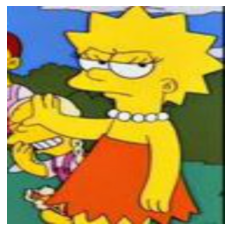

In [38]:
image_name = train_dir +"/lisa_simpson/pic_0001.jpg" #Image to be used as query
def plotLisa(image_location):
    image = cv2.imread(image_name)
    image = cv2.resize(image, (512,512))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
plotLisa(image_name)

In [39]:
train_datagen = ImageDataGenerator( rescale = 1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2
                                    )

test_datagen = ImageDataGenerator(rescale=1./255)

In [40]:
training_set =  train_datagen.flow_from_directory(
                                                    train_dir,
                                                    target_size=image_size[:2],
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb'

)

val_set =  test_datagen.flow_from_directory(
                                                    val_dir,
                                                    target_size=image_size[:2],
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    color_mode='rgb'

)

Found 18876 images belonging to 43 classes.
Found 2118 images belonging to 43 classes.


In [41]:
for data_batch, labels_batch in training_set:
    print(data_batch.shape)
    break

(100, 64, 64, 3)


In [42]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=image_size, activation="relu"))
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation="relu"))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding='same', activation="relu")) 
model.add(Conv2D(256, (3, 3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(len(labels), activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 29, 29, 64)        36928     
                                                        

In [43]:
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

In [44]:
model.save('model1.h5')

In [45]:
checkpoint_filepath = "./model.h5"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

callbacks = [
             EarlyStopping(patience=5, monitor="val_accuracy", mode="max"),
             model_checkpoint_callback,
]

In [46]:
history = model.fit_generator(  training_set,
                                epochs=epochs,
                                validation_data=val_set,
                                callbacks = callbacks
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/10
189/189 [==============================] - 737s 4s/step - loss: 3.0701 - accuracy: 0.1265 - val_loss: 2.6858 - val_accuracy: 0.2724
Epoch 2/10
189/189 [==============================] - 730s 4s/step - loss: 2.5187 - accuracy: 0.2961 - val_loss: 2.0923 - val_accuracy: 0.4372
Epoch 3/10
189/189 [==============================] - 725s 4s/step - loss: 1.9838 - accuracy: 0.4510 - val_loss: 1.4486 - val_accuracy: 0.6180
Epoch 4/10
189/189 [==============================] - 727s 4s/step - loss: 1.6067 - accuracy: 0.5563 - val_loss: 1.1130 - val_accuracy: 0.7011
Epoch 5/10
189/189 [==============================] - 727s 4s/step - loss: 1.3601 - accuracy: 0.6240 - val_loss: 0.9791 - val_accuracy: 0.7309
Epoch 6/10
189/189 [==============================] - 725s 4s/step - loss: 1.1652 - accuracy: 0.6776 - val_loss: 0.8636 - val_accuracy: 0.7573
Epoch 7/10
189/189 [==============================] - 716s 4s/step - loss: 1.0497 - accuracy: 0.7095 - val_loss: 0.7281 - val_accuracy: 0.8008

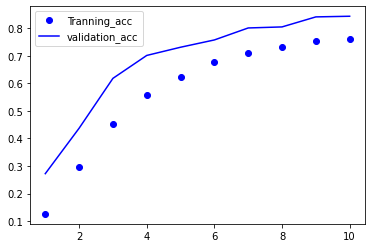

In [47]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Tranning_acc")
plt.plot(epochs, val_acc, "b", label="validation_acc")
plt.legend()

In [48]:
saved_model = keras.models.load_model('./model.h5')

In [49]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

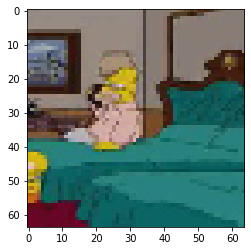

In [50]:
img_path = "../content/drive/MyDrive/kaggle_simpson_testset/kaggle_simpson_testset/abraham_grampa_simpson_13.jpg"
img = image.load_img(img_path, target_size=(64, 64, 3))
plt.imshow(img)
plt.show()

In [51]:
def predict(img):
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)
    prediction = saved_model.predict(img_batch)
    prediction = labels[np.argmax(prediction)]
    return prediction

In [52]:
predict(img)

'agnes_skinner'